# Implementation

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import warnings
import numpy as np
import theano.tensor as tt

from pymc3 import Model, Normal, Wald, glm, plot_posterior_predictive_glm, sample

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
warnings.filterwarnings("ignore")

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [4]:
RANDOM_SEED = 2022
rng = np.random.default_rng(RANDOM_SEED)

## Data loading

In [5]:
f = open("spambase.columns", "r")
headers = [line.split(":")[0] for line in f]+["class"]

df = pd.read_csv("spambase.data", header=None) 
df.columns = headers
df["class"] = df["class"].replace(0,-1)

df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,-1
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,-1
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,-1
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,-1


In [6]:
# Compute X by multiplying each row by the class
X = np.array(df.drop('class', axis=1)) * np.array(df["class"]).reshape(-1,1)

In [7]:
# Number of samples and of dimensions
n, k = X.shape
n, k

(4601, 57)

In [8]:
# Compute variance matrix
sigma = df.drop('class', axis=1).std(axis=0)
sigma2 = np.diag(df.drop('class', axis=1).var(axis=0))
sigma2_inv = np.linalg.inv(sigma2)
sigma2_inv.shape

(57, 57)

In [9]:
def numerical(vector):
    positions = []
    vals = []
    for (position, elt) in enumerate(vector):
        if np.isinf(np.abs(elt)):
            positions.append(position)
            vals.append("inf")
        if np.isnan(elt):
            positions.append(position)
            vals.append("nan")
    return len(positions) != 0, positions, vals

In [10]:
def draw(nu,T):

    betas = np.zeros((T,k))
    lambdas = np.zeros((T,n))
    omegas = np.zeros((T,k))

    betas[0] = np.ones(k)
    lambdas[0] = rng.normal(0,1,size=n)
    omegas[0] = rng.normal(0,1,size=k)

    lambdas_idx = list(range(n))
    omegas_idx = list(range(k))

    for t in range(1,T):

#         print("Step ", t)

        num_omega = numerical(1/omegas[t-1])
        if num_omega[0]:
            print("At time", t)
            idx, tags = num_omega[1], num_omega[2]
            print("Found a numerical issue for omega, in position {}, with value {}".format(i,tag))
            print("Sparsity condition reached for beta[{}]".format(i))
            betas[:,idx] = 0
            for i in idx:
                if i in omegas_idx:
                    omegas_idx.remove(i)
            print('Remaining coeffs in omega : {}'.format(len(omegas_idx)))

        num_lambda = numerical(1/lambdas[t-1])
        if num_lambda[0]:
            print("At time", t)
            idx, tag = num_lambda[1], num_lambda[2]
            print("Found a numerical issue for lambda, in position {}, with value {}".format(i,tag))
            print("Support vector found at index {}".format(i))
            lambdas[:,idx] = np.nan
            for i in idx:
                if i in lambdas_idx:
                    lambdas_idx.remove(i)
            print('Remaining coeffs in lambda : {}'.format(len(lambdas_idx)))

        # Computing B and b
        term1 = nu**(-2)* sigma2_inv[omegas_idx,:][:,omegas_idx] @ np.diag(1/omegas[t-1][omegas_idx])
        term2 = X[lambdas_idx,:][:,omegas_idx].T @ np.diag(1/lambdas[t-1][lambdas_idx]) @ X[lambdas_idx,:][:,omegas_idx]
        B = term1 + term2
        b = B @ X[lambdas_idx,:][:,omegas_idx].T @ (np.ones(len(lambdas_idx)) + 1/lambdas[t-1][lambdas_idx])

        # Sampling beta using previous state
        betas[t][omegas_idx] = rng.multivariate_normal(b, cov=B)

        # Sampling lambda using beta
        for i in lambdas_idx:
            lambda_inv = rng.wald(1/np.abs(1-X[i][omegas_idx].T @ betas[t][omegas_idx]), 1)
            while lambda_inv == 0.0:
                lambda_inv = rng.wald(1/np.abs(1-X[i][omegas_idx].T @ betas[t][omegas_idx]), 1)
            lambdas[t,i] = 1/lambda_inv

        # Sampling omega using beta
        for j in omegas_idx:
            omega_inv = rng.wald(nu*sigma[j]/np.abs(betas[t,j]), 1)
            while omega_inv == 0.0:
                omega_inv = rng.wald(nu*sigma[j]/np.abs(betas[t,j]), 1)
            omegas[t,j] = 1/omega_inv
    
    return betas

In [11]:
T = 100
nu = 1

betas1 = draw(nu,T)

In [12]:
T = 100
nu = 0.001

betas2 = draw(nu,T)

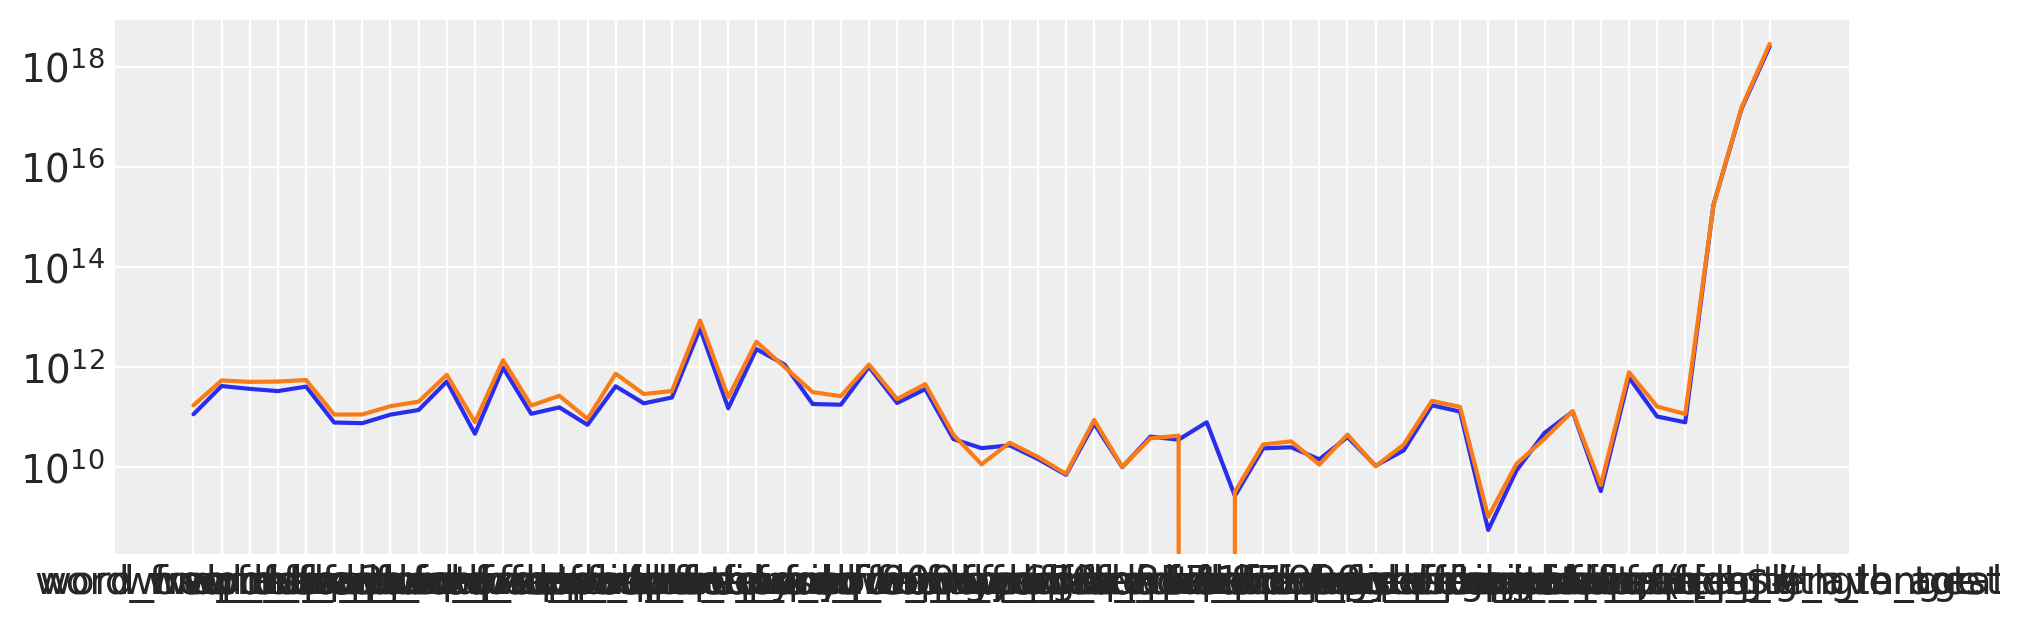

In [13]:
plt.figure(figsize=(10, 3))
coeff = np.random.randint(k)
std_betas1 = betas1[-1,:]*sigma
std_betas2 = betas2[-1,:]*sigma
plt.plot(std_betas1)
plt.plot(std_betas2)
plt.yscale("log")
plt.show()

In [14]:
# ## Model in pymc
# with Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    
#     # Define priors
#     beta = Normal("x", 0, sigma=20)
#     epsilon = Normal("Intercept", 0, sigma=20)
#     sigma = HalfCauchy("sigma", beta=10, testval=1.0)

#     # Define likelihood
#     B = 
#     b = 
#     likelihood = Normal("y", mu = beta * x + epsilon, sigma=sigma, observed=y)

#     # Inference
#     trace = sample(1000, return_inferencedata=True) # draw posterior samples using NUTS sampling

In [15]:
# az.plot_trace(trace, figsize=(10, 7));

In [16]:
# plt.figure(figsize=(7, 7))
# plt.plot(x, y, label="data", marker="x", linestyle="None")
# plot_posterior_predictive_glm(trace, samples=100, label="posterior predictive regression lines")
# plt.plot(x, true_regression_line, label="true regression line", linewidth=3.0, color="yellow")

# plt.title("Posterior predictive regression lines")
# plt.legend(loc=0)
# plt.xlabel("x")
# plt.ylabel("y");